# Importations + Fonctions générales

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, shapiro

sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "figure.autolayout": True
})

def load_csv_files(folder_path):
    all_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    datas = pd.DataFrame()
    for file in all_files:
        filename = os.path.basename(file)
        if "_" in filename:
            weather = filename.split('_')[0]
            data = pd.read_csv(file)
            data['weather'] = weather
            datas = pd.concat([datas, data], ignore_index=True)
    datas['velocity_ms'] = datas['velocity_exp2'] * (5 / 18)
    datas['avg_safety_time'] = datas['avg_safety_distance'] / datas['velocity_ms']
    return datas.dropna()

def prepare_data(datas, limit=None):
    if limit is not None:
        datas = datas[datas['avg_safety_time'] < limit]
    datas['height^2'] = datas['height'] ** 2
    datas['velocity_exp2^2'] = datas['velocity_exp2'] ** 2
    datas['height*velocity'] = datas['height'] * datas['velocity_exp2']
    return datas


# Chargement + préparation des données

In [2]:
folder_path = r'E:\crossing-model\main_experiment\model_datas'
datas = load_csv_files(folder_path)
datas_prepared = prepare_data(datas, 7)
datas_prepared

C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\1927632173.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas['height^2'] = datas['height'] ** 2
C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\1927632173.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas['velocity_exp2^2'] = datas['velocity_exp2'] ** 2
C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\1927632173.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

,participant_id,avg_safety_distance,height,age,d_l,d_m,d_h,distance_category,velocity_exp1,velocity_exp2,weather,velocity_ms,avg_safety_time,height^2,velocity_exp2^2,height*velocity
0,XXX_43,48.783020,157,25,-12.202150,17.071533,-32.350967,odd,60,70,clear,19.444444,2.508841,24649,4900,10990
1,XXX_40,91.593208,161,26,-19.918000,-34.863283,-39.402067,odd,60,70,clear,19.444444,4.710508,25921,4900,11270
2,XXX_39,62.062988,190,26,-23.496700,-9.490967,-33.917549,odd,60,70,clear,19.444444,3.191811,36100,4900,13300
3,XXX_36,64.247789,187,27,3.117067,3.191532,2.513218,pair,60,70,clear,19.444444,3.304172,34969,4900,13090
4,XXX_34,35.943017,173,29,9.144283,55.509850,16.966347,pair,60,70,clear,19.444444,1.848498,29929,4900,12110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,XXX_33,33.976159,176,48,-7.314861,1.445000,0.129375,pair,50,40,rain,11.111111,3.057854,30976,1600,7040
167,XXX_31,49.867694,175,27,-10.448000,-18.611416,-20.211861,pair,50,40,rain,11.111111,4.488092,30625,1600,7000
168,XXX_30,62.882006,167,60,-9.828750,0.488766,-14.922569,pair,50,40,rain,11.111111,5.659381,27889,1600,6680
169,XXX_27,43.972218,178,26,-8.558444,-1.531319,-11.824623,pair,50,40,rain,11.111111,3.957500,31684,1600,7120


# Entraînement du modèle + Split + Cross-Validation

In [3]:
def modeling_and_plots(datas,has_mask=False):

    features = ['height', 'height^2', 'velocity_exp2']
    target = 'avg_safety_time'
    weather_col = 'weather'
    participant_col = 'participant_id'


    X = datas[features]
    y = datas[target]
    weather = datas[weather_col]

    # Split 80/20
    participants = datas[participant_col]

    X_train, X_test, y_train, y_test, weather_train, weather_test, participant_train, participant_test = train_test_split(
        X, y, weather, participants, test_size=0.2, random_state=42
    )


    # Cross-validation 10 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    alphas_cv = {w: [] for w in weather.unique()}
    coefs_cv = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        weather_val = weather_train.iloc[val_idx]

        model = LinearRegression()
        model.fit(X_tr, y_tr)

        y_val_pred = model.predict(X_val)
        coefs_cv.append(np.append(model.coef_, model.intercept_))

        df_val = pd.DataFrame({'y_true': y_val, 'y_pred': y_val_pred, 'weather': weather_val})
        for w in alphas_cv.keys():
            subset = df_val[df_val['weather'] == w]
            if len(subset) > 0:
                alpha = subset['y_true'].mean() / subset['y_pred'].mean()
                alphas_cv[w].append(alpha)

    coefs_cv = np.array(coefs_cv)
    coef_means = coefs_cv[:, :3].mean(axis=0)
    coef_stds = coefs_cv[:, :3].std(axis=0)
    intercept_mean = coefs_cv[:, 3].mean()
    intercept_std = coefs_cv[:, 3].std()

    alpha_means = {w: np.mean(vals) for w, vals in alphas_cv.items()}
    alpha_stds = {w: np.std(vals) for w, vals in alphas_cv.items()}

    # Texte résultats
    txt = "=== Résultats Cross-validation ===\n"
    txt += "Coefficients fixes (mean ± std):\n"
    for var, mean_, std_ in zip(features, coef_means, coef_stds):
        txt += f"  {var}: {mean_:.4f} ± {std_:.4f}\n"
    txt += f"  intercept: {intercept_mean:.4f} ± {intercept_std:.4f}\n\n"
    txt += "Coefficients multiplicateurs alpha par météo (mean ± std):\n"
    for w in alpha_means.keys():
        txt += f"  {w}: {alpha_means[w]:.4f} ± {alpha_stds[w]:.4f}\n"

    # Entraînement final sur train complet
    final_model = LinearRegression()
    final_model.fit(X_train, y_train)

    y_train_pred = final_model.predict(X_train)
    df_train = pd.DataFrame({'y_true': y_train, 'y_pred': y_train_pred, 'weather': weather_train})

    alphas_final = {}
    for w in alpha_means.keys():
        subset = df_train[df_train['weather'] == w]
        alphas_final[w] = subset['y_true'].mean() / subset['y_pred'].mean()

    txt += "\n=== Équation factorisée finale après entraînement complet sur train 80% ===\n"
    coefs = final_model.coef_
    intercept = final_model.intercept_
    for w, alpha in alphas_final.items():
        eq_terms = " + ".join([f"{c:.4f}*{f}" for c, f in zip(coefs, features)])
        txt += f"{w} : y = {alpha:.4f} * ({eq_terms} + {intercept:.4f})\n"


    # Évaluation sur test
    y_test_pred_raw = final_model.predict(X_test)
    alpha_array = weather_test.map(alphas_final).values
    y_test_pred = pd.Series(y_test_pred_raw * alpha_array, index=y_test.index)

    # Filtrer les valeurs où y_test <= 7
    if has_mask :
        mask = y_test <= 5
        y_test_filtered = y_test[mask]
        y_pred_filtered = y_test_pred[mask]

        mae_test = mean_absolute_error(y_test_filtered, y_pred_filtered)
        rmse_test = mean_squared_error(y_test_filtered, y_pred_filtered)
        r2_test = r2_score(y_test_filtered, y_pred_filtered)
    else :
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)


    txt += "\n=== Évaluation sur test 20% ===\n"
    txt += f"MAE: {mae_test:.4f}\n"
    txt += f"RMSE: {rmse_test:.4f}\n"
    txt += f"R²: {r2_test:.4f}\n"

    # --- Calcul std et mean erreur par météo ---
    df_error = pd.DataFrame({'weather': weather_test, 'error': y_test - y_test_pred})
    df_error = df_error[y_test <= 7]
    
    # Pour chaque météo, calcul std et mean des erreurs
    std_me_per_weather = {}
    for w in df_error['weather'].unique():
        subset_err = df_error[df_error['weather'] == w]['error']
        std_me_per_weather[w] = {
            'std': subset_err.std(),
            'me': subset_err.mean()
        }
        
        
    # --- Binned trend plot: test set points + baseline + 5-bin average with standard error ---
    df_bin = pd.DataFrame({
        'y_true': y_test,
        'y_pred': y_test_pred
    })

    df_bin['participant'] = participant_test.values
    df_bin['height'] = X_test['height'].values
    df_bin['velocity_exp2'] = X_test['velocity_exp2'].values
    df_bin['weather'] = weather_test.values


    # Ajout des prédictions ajustées par météo (pred - 2*std + me)
    y_pred_adjusted = y_test_pred.copy()
    for w in std_me_per_weather.keys():
        idxs = weather_test[weather_test == w].index
        std_ = std_me_per_weather[w]['std']
        me_ = std_me_per_weather[w]['me']
        y_pred_adjusted.loc[idxs] = y_pred_adjusted.loc[idxs] - 2 * std_ + me_

    df_bin['y_pred_adjusted'] = y_pred_adjusted

        
    return txt, X_test, y_test, weather_test, y_test_pred, participant_test, df_bin



In [4]:
folder_path = r'C:\Users\svictor\Documents\model_datas'
datas = load_csv_files(folder_path)
datas_prepared = prepare_data(datas, 7)
txt, X_test, y_test, weather_test, y_test_pred, participant_test, df_bin = modeling_and_plots(datas_prepared, has_mask=False)
print(txt)

=== Résultats Cross-validation ===
Coefficients fixes (mean ± std):
  height: -1.3598 ± 0.1736
  height^2: 0.0039 ± 0.0005
  velocity_exp2: -0.0539 ± 0.0023
  intercept: 125.9215 ± 14.8935

Coefficients multiplicateurs alpha par météo (mean ± std):
  clear: 1.0339 ± 0.0446
  night: 0.9924 ± 0.1167
  rain: 0.9620 ± 0.0473

=== Équation factorisée finale après entraînement complet sur train 80% ===
clear : y = 1.0364 * (-1.3502*height + 0.0038*height^2 + -0.0540*velocity_exp2 + 125.0461)
night : y = 0.9967 * (-1.3502*height + 0.0038*height^2 + -0.0540*velocity_exp2 + 125.0461)
rain : y = 0.9606 * (-1.3502*height + 0.0038*height^2 + -0.0540*velocity_exp2 + 125.0461)

=== Évaluation sur test 20% ===
MAE: 0.7294
RMSE: 0.8938
R²: 0.4827



C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\1927632173.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas['height^2'] = datas['height'] ** 2
C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\1927632173.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas['velocity_exp2^2'] = datas['velocity_exp2'] ** 2
C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\1927632173.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

#  Analyse des résidus + Graphes

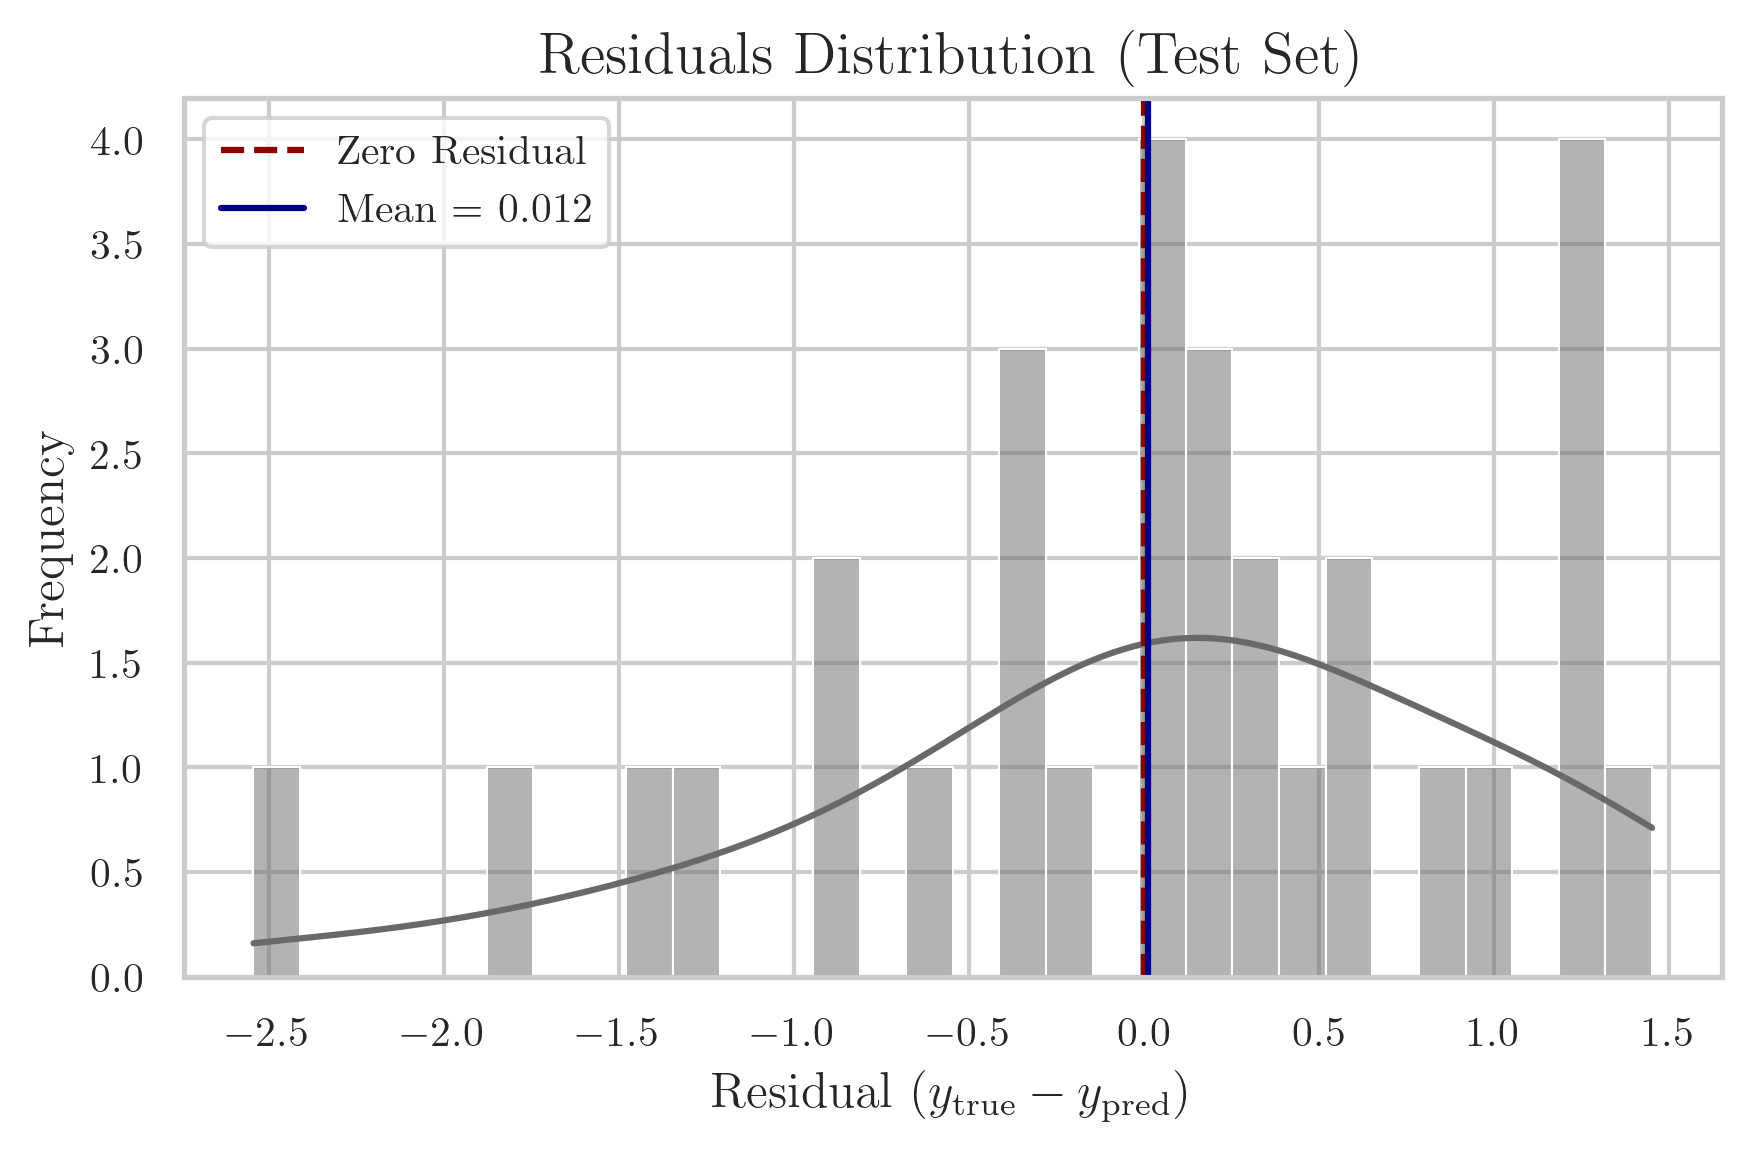

MAE = 0.729
Pearson correlation r = 0.700, p-value = 1.647e-05
Shapiro-Wilk stat = 0.953, p = 1.983e-01
✅ Residuals appear normally distributed (p > 0.05)


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, pearsonr
from sklearn.metrics import mean_absolute_error

# IEEE-like style with sober, visible colors
sns.set_theme(style="whitegrid", palette=['navy', 'darkred', 'dimgray'])

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "figure.autolayout": True
})

# --- Residuals ---
residuals = y_test - y_test_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True, color='dimgray', edgecolor='white', linewidth=0.5)
plt.axvline(0, color='darkred', linestyle='--', label='Zero Residual')
plt.axvline(residuals.mean(), color='navy', linestyle='-', label=fr'Mean = {residuals.mean():.3f}')
plt.title(r'Residuals Distribution (Test Set)')
plt.xlabel(r'Residual ($y_\mathrm{true} - y_\mathrm{pred}$)')
plt.ylabel(r'Frequency')
plt.legend()
plt.grid(True)
plt.show()

# --- Statistics ---
mae = mean_absolute_error(y_test, y_test_pred)
r, pval = pearsonr(y_test, y_test_pred)
stat, p_shapiro = shapiro(residuals)

print(f"MAE = {mae:.3f}")
print(f"Pearson correlation r = {r:.3f}, p-value = {pval:.3e}")
print(f"Shapiro-Wilk stat = {stat:.3f}, p = {p_shapiro:.3e}")

if p_shapiro > 0.05:
    print("✅ Residuals appear normally distributed (p > 0.05)")
else:
    print("⚠️ Residuals do not appear normal (p ≤ 0.05)")


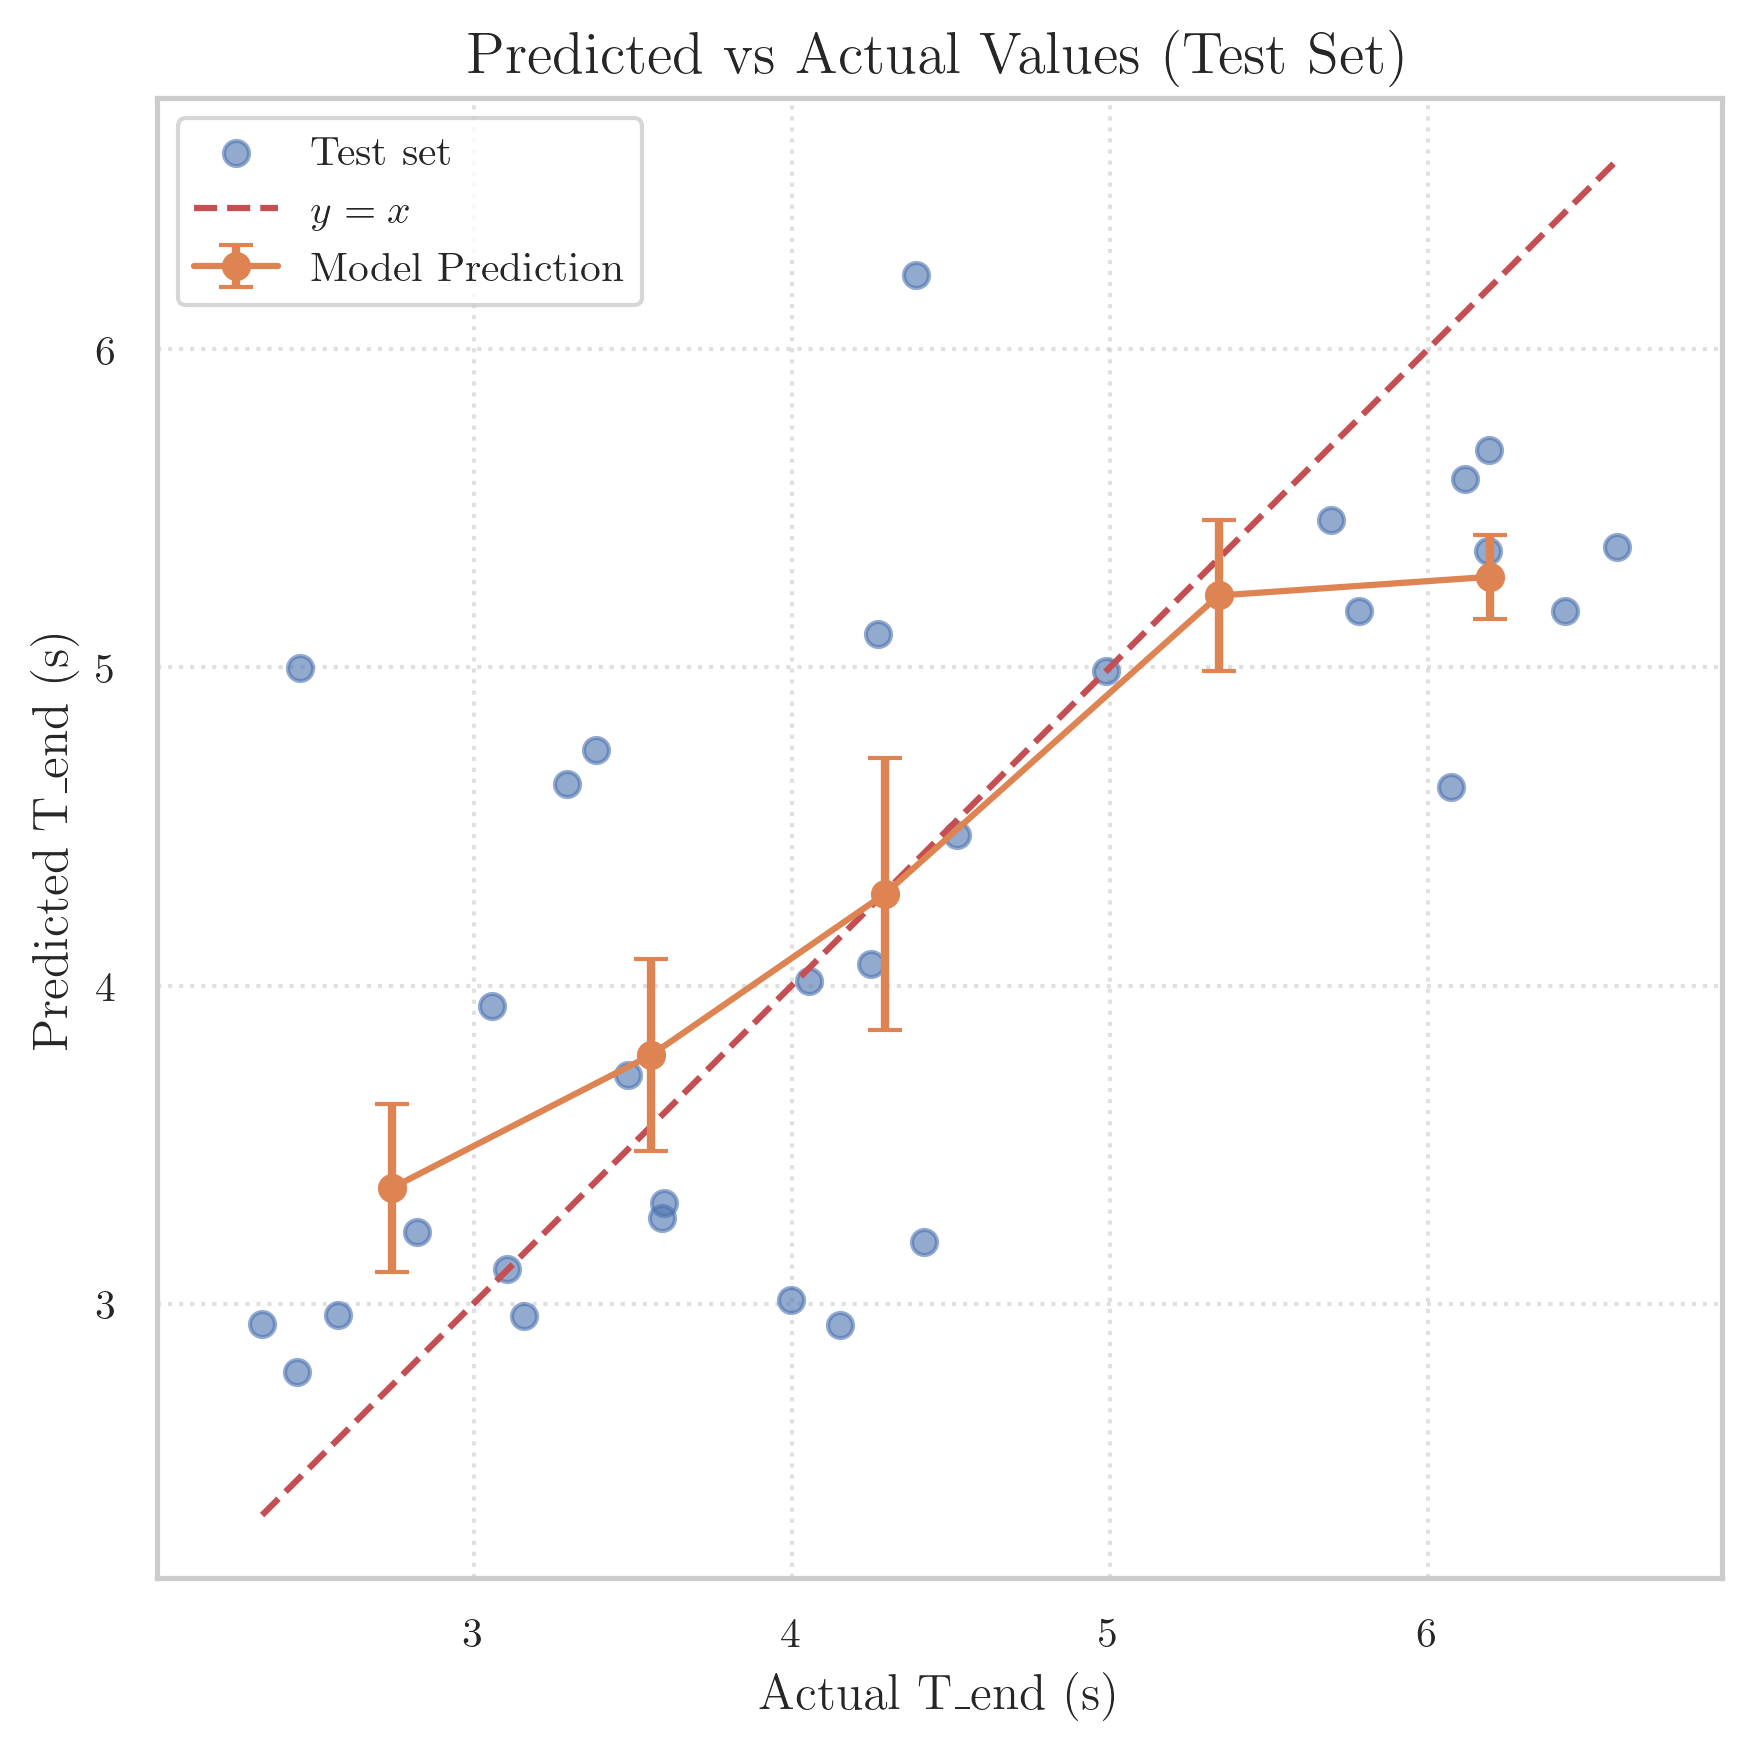

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Assume df_bin contient 'y_true' et 'y_pred'

nb_bins = 5
df_bin['bin'] = pd.cut(df_bin['y_true'], bins=nb_bins)

bin_stats = df_bin.groupby('bin').agg(
    mean_y_true=('y_true', 'mean'),
    mean_y_pred=('y_pred', 'mean'),
    std_y_pred=('y_pred', 'std'),
    count=('y_pred', 'count')
).reset_index()

bin_stats['std_error'] = bin_stats['std_y_pred'] / np.sqrt(bin_stats['count'])

min_val = min(df_bin['y_true'].min(), df_bin['y_pred'].min())
max_val = max(df_bin['y_true'].max(), df_bin['y_pred'].max())

plt.figure(figsize=(6,6))

palette = sns.color_palette("deep")

scatter_color = palette[0]   # Couleur 1 pour scatter points
binned_color = palette[1]    # Couleur 2 pour binned trend + barres erreur (même couleur)

plt.scatter(df_bin['y_true'], df_bin['y_pred'], alpha=0.6, color=scatter_color, label='Test set')

plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label=r'$y = x$')

plt.errorbar(
    bin_stats['mean_y_true'],
    bin_stats['mean_y_pred'],
    yerr=bin_stats['std_error'],
    fmt='o-', color=binned_color, ecolor=binned_color,
    elinewidth=2, capsize=4,
    label='Model Prediction'
)

plt.title(r'Predicted vs Actual Values (Test Set)')
plt.xlabel(r'Actual T_{end} (s)')
plt.ylabel(r'Predicted T_{end} (s)')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


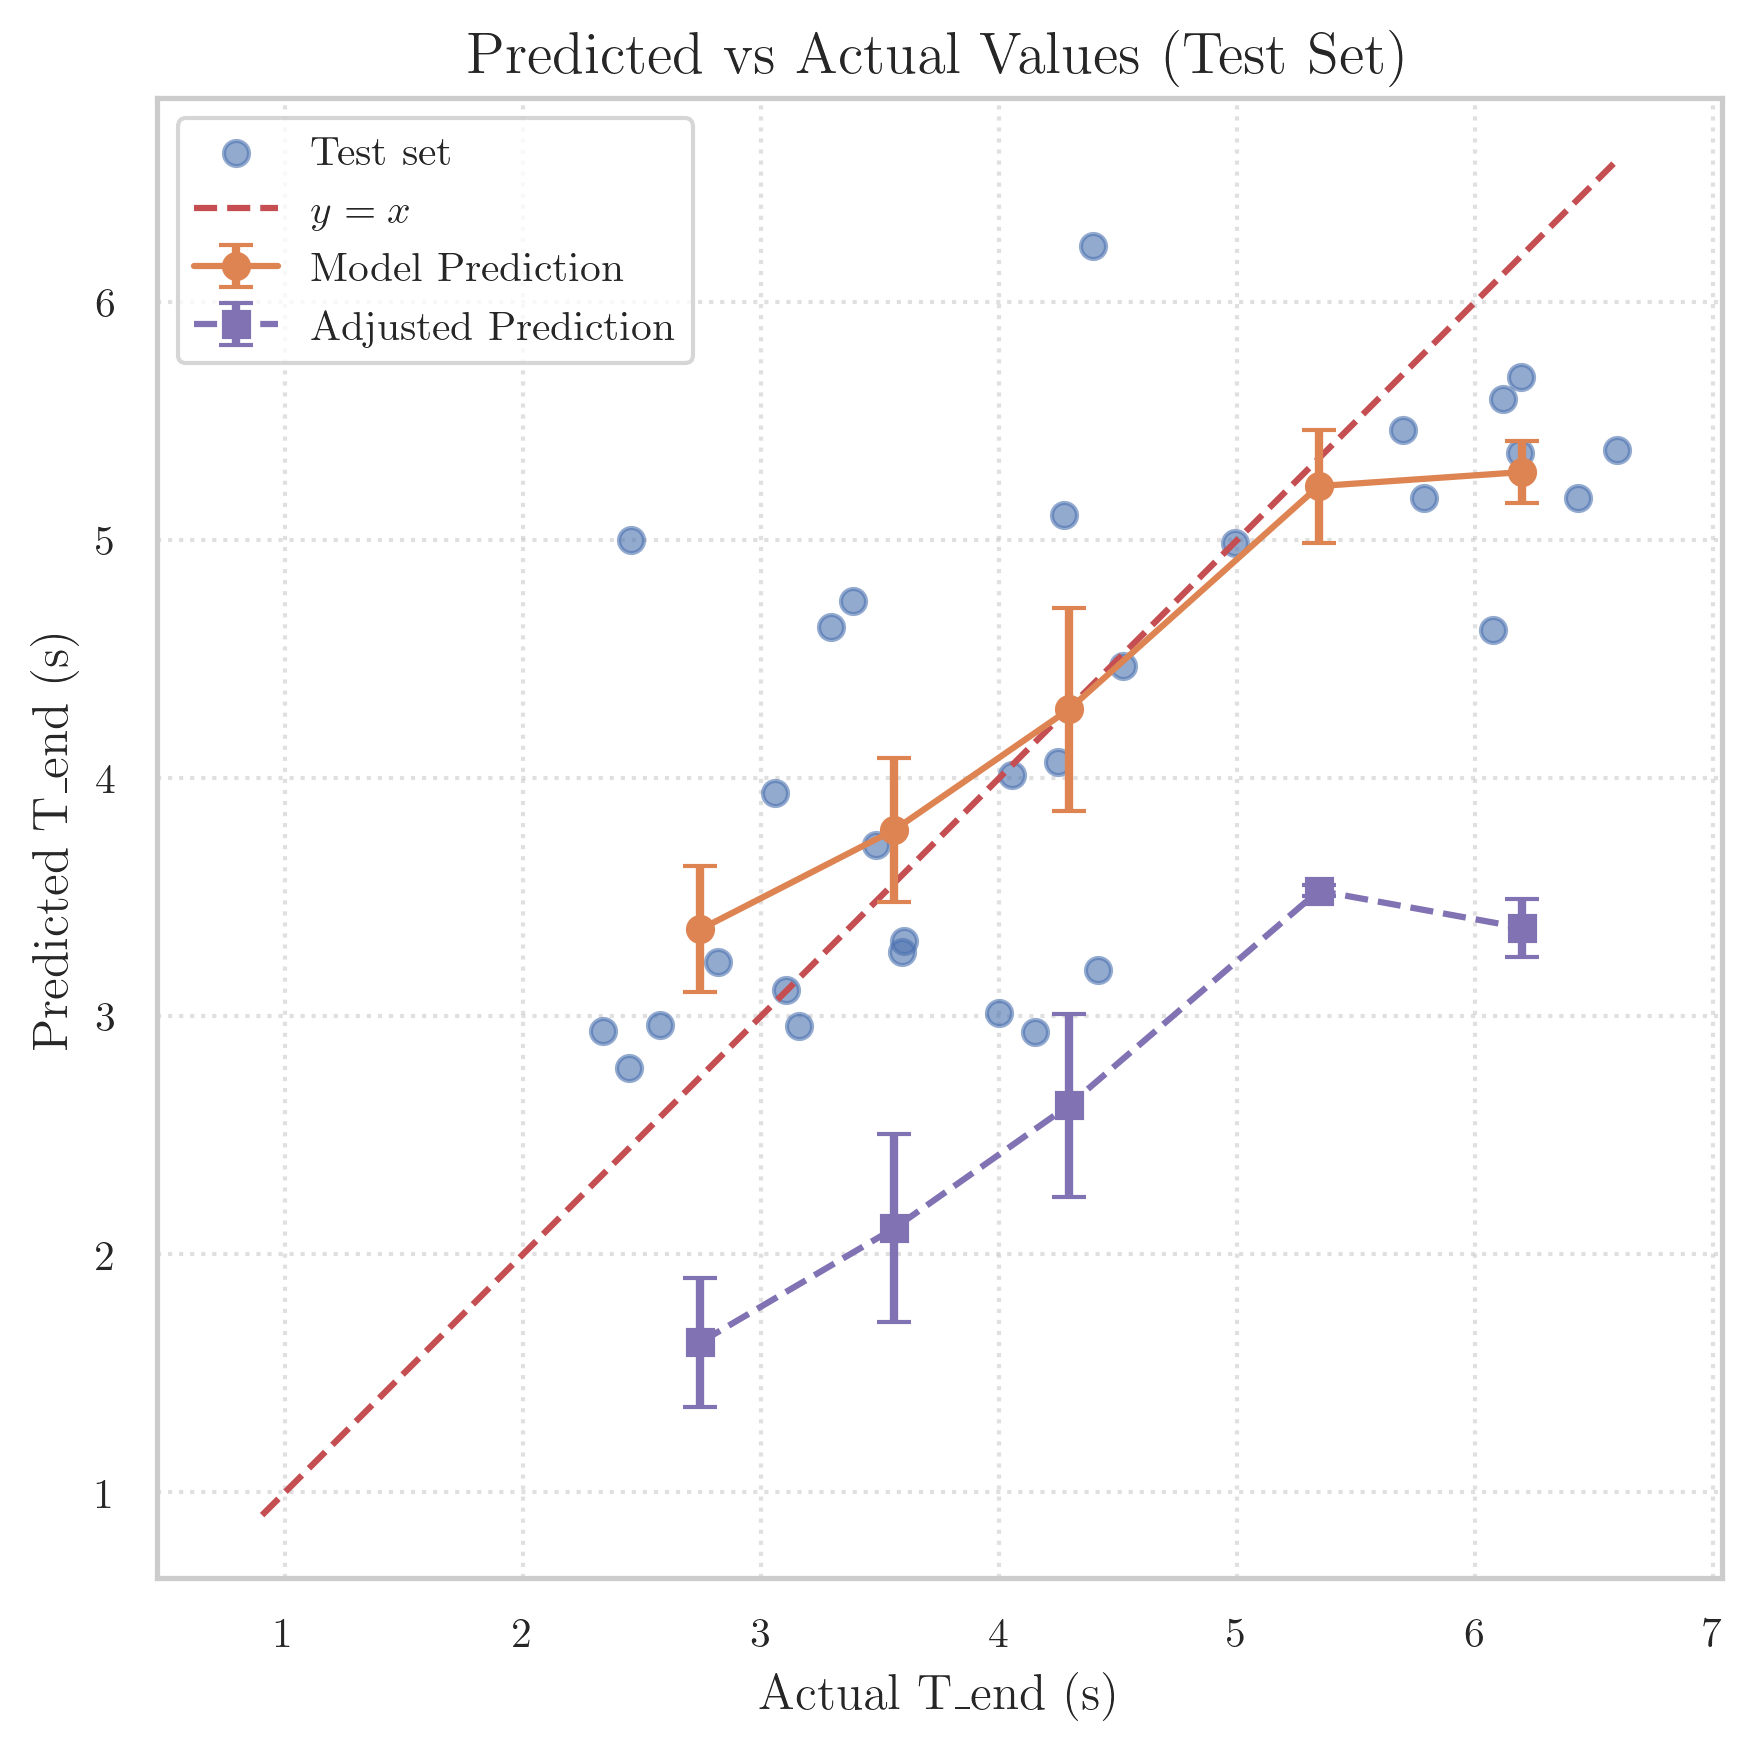

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Assume df_bin contient 'y_true', 'y_pred' et 'weather'
stds = {
    'clear': 1.0,
    'night': 0.94,
    'rain': 0.72
}
mes = {
    'clear': 0.04,
    'night': 0.00,
    'rain': 0.00
}

# Calcul adjusted_time
df_bin['adjusted_pred'] = df_bin.apply(
    lambda row: row['y_pred'] - 2 * stds[row['weather']] + mes[row['weather']],
    axis=1
)

# Binning
nb_bins = 5
df_bin['bin'] = pd.cut(df_bin['y_true'], bins=nb_bins)

# Statistiques binned pour y_pred
bin_stats = df_bin.groupby('bin').agg(
    mean_y_true=('y_true', 'mean'),
    mean_y_pred=('y_pred', 'mean'),
    std_y_pred=('y_pred', 'std'),
    count=('y_pred', 'count')
).reset_index()
bin_stats['std_error'] = bin_stats['std_y_pred'] / np.sqrt(bin_stats['count'])

# Statistiques binned pour adjusted_pred
bin_stats_adj = df_bin.groupby('bin').agg(
    mean_y_true=('y_true', 'mean'),
    mean_adjusted_pred=('adjusted_pred', 'mean'),
    std_adjusted_pred=('adjusted_pred', 'std'),
    count=('adjusted_pred', 'count')
).reset_index()
bin_stats_adj['std_error'] = bin_stats_adj['std_adjusted_pred'] / np.sqrt(bin_stats_adj['count'])

# Plot
min_val = min(df_bin['y_true'].min(), df_bin['y_pred'].min(), df_bin['adjusted_pred'].min())
max_val = max(df_bin['y_true'].max(), df_bin['y_pred'].max(), df_bin['adjusted_pred'].max())

plt.figure(figsize=(6,6))
palette = sns.color_palette("deep")

scatter_color = palette[0]   # bleu
binned_color = palette[1]    # orange (courbe existante)
adjusted_color = palette[4]  # violet (nouvelle courbe)

# Points scatter
plt.scatter(df_bin['y_true'], df_bin['y_pred'], alpha=0.6, color=scatter_color, label='Test set')

# Ligne y = x
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label=r'$y = x$')

# Courbe binned originale (orange)
plt.errorbar(
    bin_stats['mean_y_true'],
    bin_stats['mean_y_pred'],
    yerr=bin_stats['std_error'],
    fmt='o-', color=binned_color, ecolor=binned_color,
    elinewidth=2, capsize=4,
    label='Model Prediction'
)

# Courbe binned ajustée (violet)
plt.errorbar(
    bin_stats_adj['mean_y_true'],
    bin_stats_adj['mean_adjusted_pred'],
    yerr=bin_stats_adj['std_error'],
    fmt='s--', color=adjusted_color, ecolor=adjusted_color,
    elinewidth=2, capsize=4,
    label='Adjusted Prediction'
)

# Layout
plt.title(r'Predicted vs Actual Values (Test Set)')
plt.xlabel(r'Actual T_{end} (s)')
plt.ylabel(r'Predicted T_{end} (s)')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


# Analyse d’interprétabilité (erreurs vs variables)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Palettes définies par toi
weather_palette = {
    "clear": "#ffffb3",
    "rain": "#8dd3c7",
    "night": "#bebada"
}

velocity_palette = {
    20: "#66c2a5",
    30: "#fc8d62",
    40: "#8da0cb",
    50: "#e78ac3",
    60: "#a6d854",
    70: "#ffd92f"
}

height_bins = pd.IntervalIndex([
    pd.Interval(156.999, 167.0, closed='right'),
    pd.Interval(167.0, 171.0, closed='right'),
    pd.Interval(171.0, 176.0, closed='right'),
    pd.Interval(176.0, 180.0, closed='right'),
    pd.Interval(180.0, 190.0, closed='right')
])

height_colors = sns.color_palette("Blues", n_colors=len(height_bins)).as_hex()
height_palette = dict(zip(height_bins, height_colors))

def map_interval_to_color(value, palette):
    for interval, color in palette.items():
        if value == interval:
            return color
    return "#000000"  # fallback

In [9]:
errors_abs = np.abs(y_test - y_test_pred)
df_errors = pd.DataFrame({
    'Height': X_test['height'].values,
    'Velocity_exp2': X_test['velocity_exp2'].values,
    'Weather': weather_test.values,
    'Error_abs': errors_abs.values,
    'Participant': participant_test.values
})

# Binning height and converting intervals to string for palette mapping in boxplot
df_errors['Height_bin'] = pd.cut(df_errors['Height'], bins=height_bins)
df_errors['Height_bin_str'] = df_errors['Height_bin'].astype(str)

# Velocity as string for palette matching
df_errors['Velocity_cat'] = df_errors['Velocity_exp2'].astype(int).astype(str)



In [10]:
weather_palette = {
    "clear": "#ffffb3",
    "rain": "#8dd3c7",
    "night": "#bebada"
}

velocity_palette = {
    20: "#66c2a5",
    30: "#fc8d62",
    40: "#8da0cb",
    50: "#e78ac3",
    60: "#a6d854",
    70: "#ffd92f"
}

velocity_palette_str = {str(k): v for k, v in velocity_palette.items()}

height_colors = sns.color_palette("Blues", n_colors=len(height_bins)).as_hex()
height_palette = dict(zip([str(interval) for interval in height_bins], height_colors))


C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\3390259459.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\3390259459.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\svictor\AppData\Local\Temp\ipykernel_45984\3390259459.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


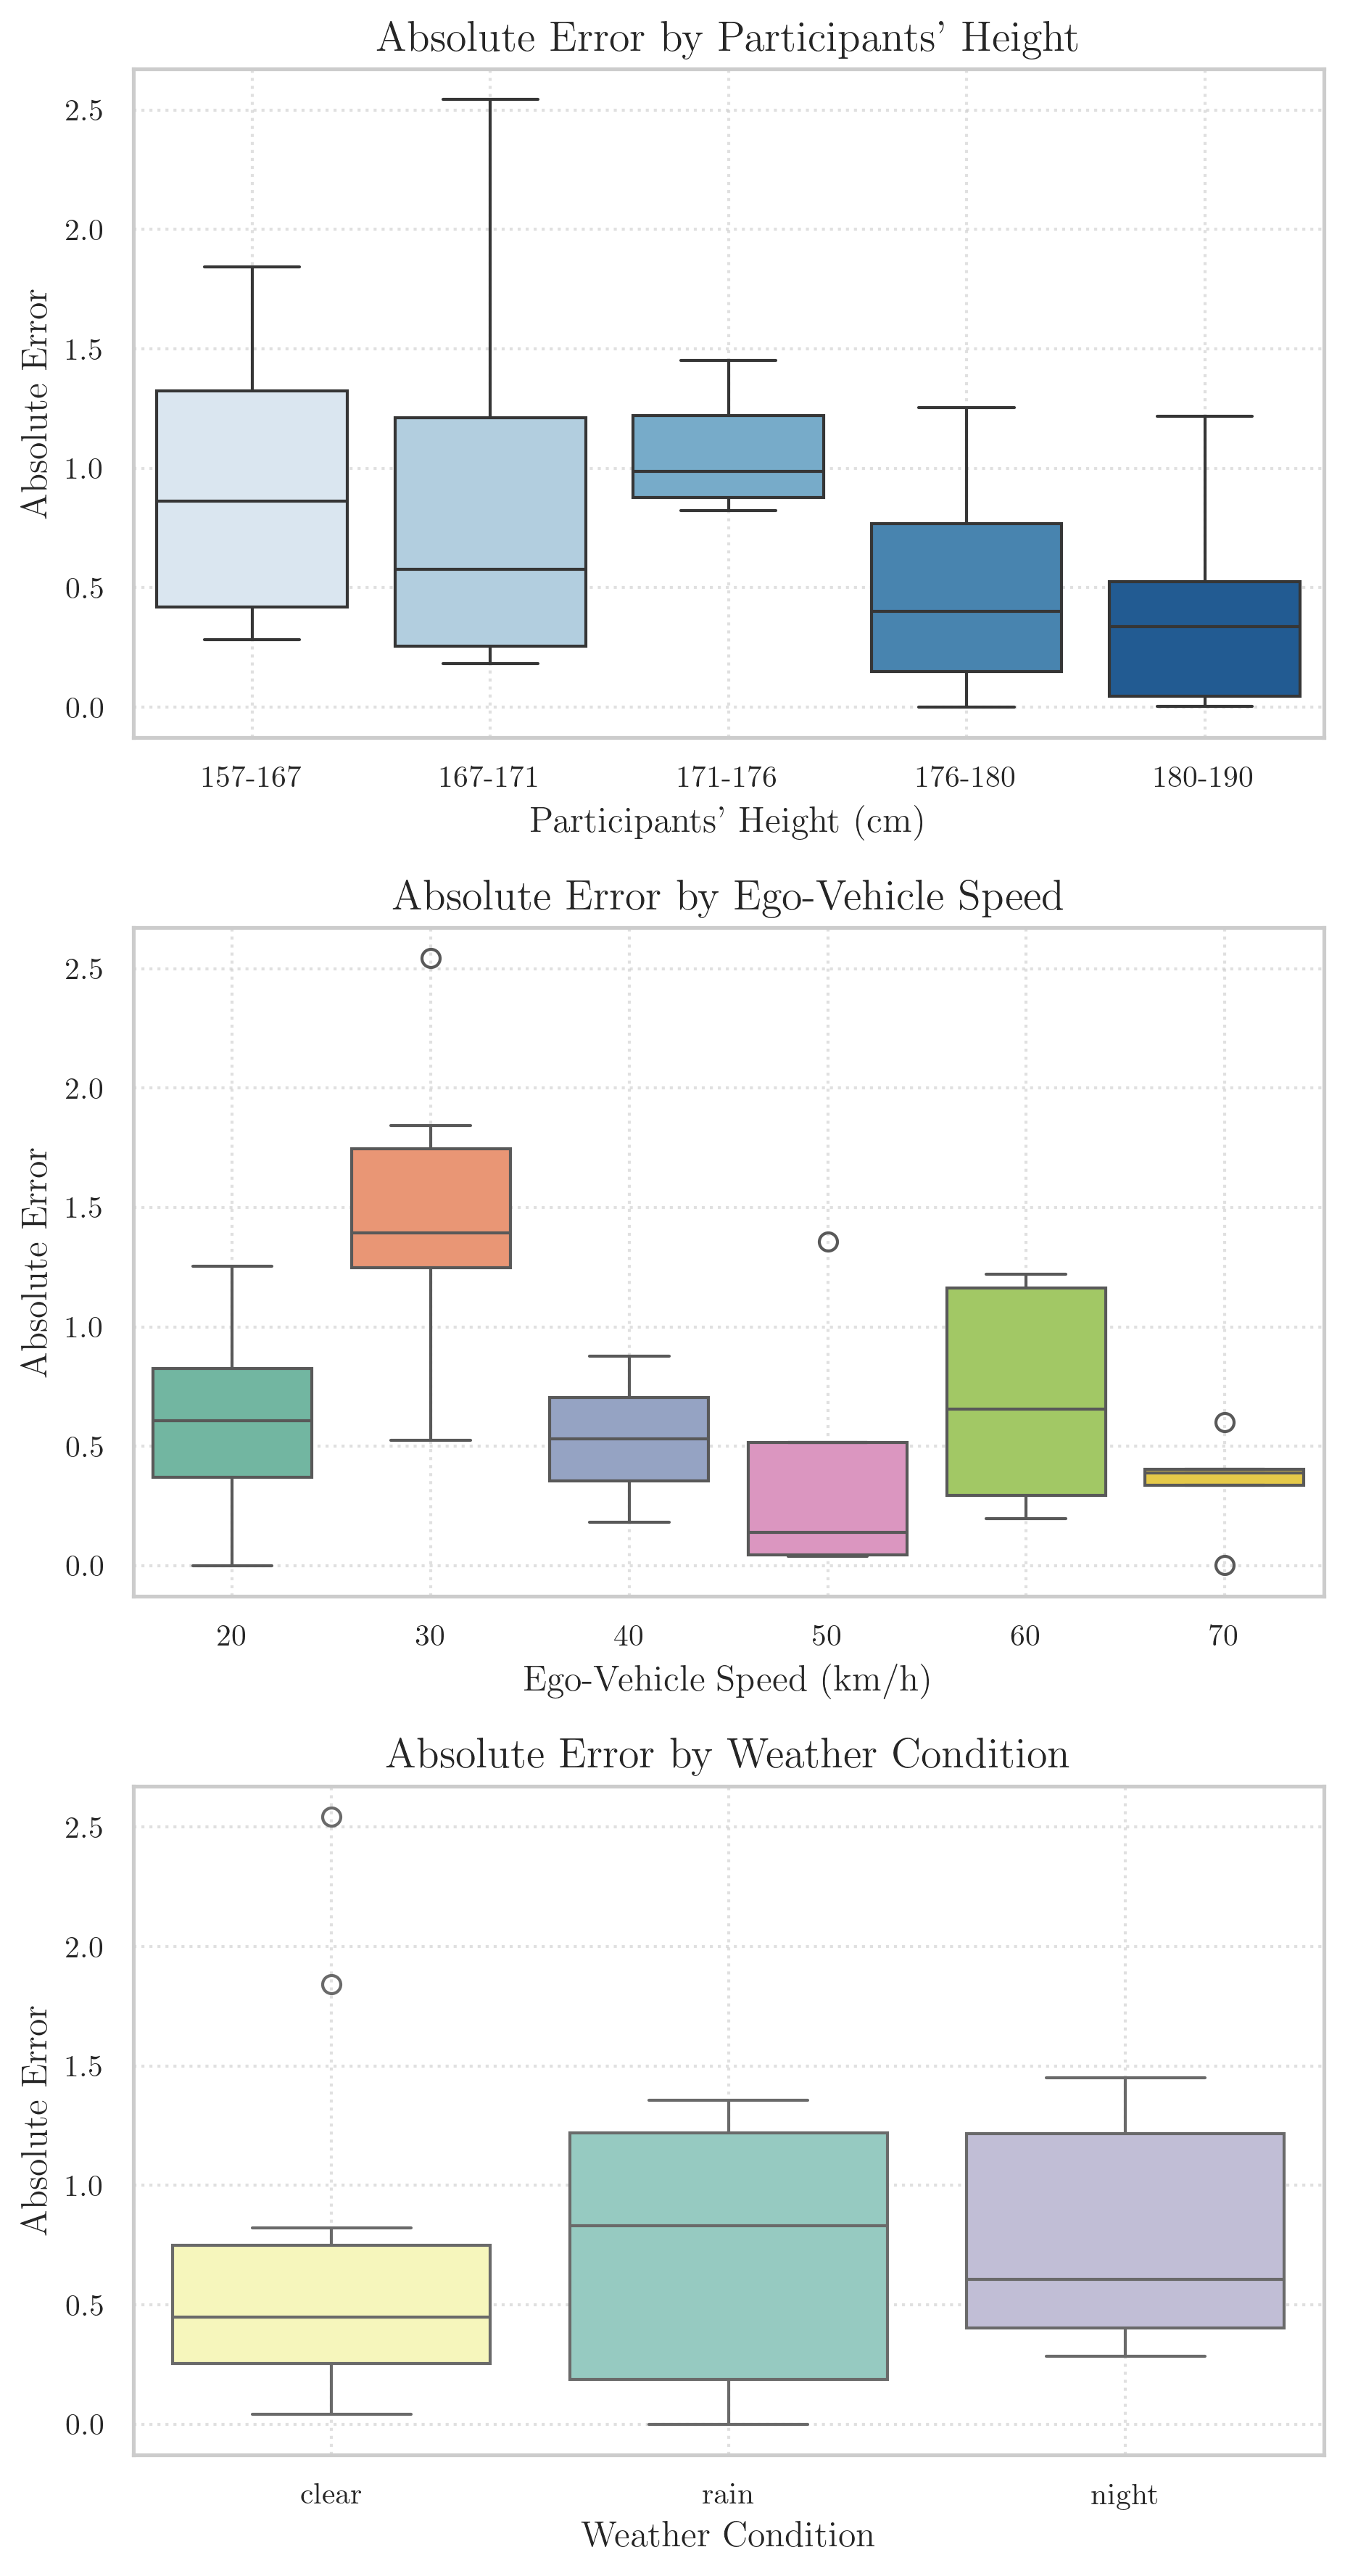


--- Boxplot stats: Height ---
                  count      mean       std       min       25%       50%  \
Height_bin_label                                                            
157-167             6.0  0.933696  0.630588  0.284142  0.419095  0.864184   
167-171             6.0  0.908567  0.915812  0.181306  0.255336  0.577452   
171-176             5.0  1.071570  0.260648  0.822736  0.878676  0.986406   
176-180             4.0  0.514617  0.553671  0.000518  0.147882  0.402260   
180-190             9.0  0.379132  0.381195  0.002494  0.046675  0.337867   

                       75%       max  
Height_bin_label                      
157-167           1.323081  1.842889  
167-171           1.211793  2.543988  
171-176           1.219770  1.450262  
176-180           0.768995  1.253431  
180-190           0.525489  1.216559  

--- Boxplot stats: Velocity ---
              count      mean       std       min       25%       50%  \
Velocity_cat                                      

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# height_bins fournis, inchangés
height_bins = pd.IntervalIndex([
    pd.Interval(156.999, 167.0, closed='right'),
    pd.Interval(167.0, 171.0, closed='right'),
    pd.Interval(171.0, 176.0, closed='right'),
    pd.Interval(176.0, 180.0, closed='right'),
    pd.Interval(180.0, 190.0, closed='right')
])

# Palette "Blues" de clair (petit) à foncé (grand)
height_colors = sns.color_palette("Blues", n_colors=len(height_bins)).as_hex()
height_palette = dict(zip(height_bins, height_colors))

# Fonction pour simplifier le label des intervalles
def simplify_interval_label(interval):
    left = int(np.ceil(interval.left))
    right = int(interval.right)
    return f"{left}-{right}"

# Ajout des colonnes dans df_errors
df_errors['Height_bin'] = pd.cut(df_errors['Height'], bins=height_bins)
df_errors['Height_bin_label'] = df_errors['Height_bin'].apply(simplify_interval_label)

# Palette avec labels simplifiés (order sera corrigé)
height_palette_labels = dict()
for interval, color in height_palette.items():
    label = simplify_interval_label(interval)
    height_palette_labels[label] = color

# Ordre croissant des labels Height
height_order = sorted(height_palette_labels.keys(), key=lambda x: int(x.split('-')[0]))

# Palette vitesse (déjà définie)
velocity_palette = {
    20: "#66c2a5",
    30: "#fc8d62",
    40: "#8da0cb",
    50: "#e78ac3",
    60: "#a6d854",
    70: "#ffd92f"
}
velocity_palette_str = {str(k): v for k, v in velocity_palette.items()}
df_errors['Velocity_cat'] = df_errors['Velocity_exp2'].astype(int).astype(str)
velocity_order = sorted(velocity_palette_str.keys(), key=int)

# Palette météo
weather_palette = {
    "clear": "#ffffb3",
    "rain": "#8dd3c7",
    "night": "#bebada"
}
weather_order = list(weather_palette.keys())

# Création figure 3 lignes x 2 colonnes (boxplots uniquement)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# --- HEIGHT Boxplot ---
sns.boxplot(
    data=df_errors,
    x='Height_bin_label',
    y='Error_abs',
    palette=height_palette_labels,
    order=height_order,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Absolute Error by Participants\' Height')
axes[0, 1].set_xlabel('Participants\' Height (cm)')
axes[0, 1].set_ylabel('Absolute Error')
axes[0, 1].grid(True, linestyle=':', alpha=0.6)

# --- VELOCITY Boxplot ---
sns.boxplot(
    data=df_errors,
    x='Velocity_cat',
    y='Error_abs',
    palette=velocity_palette_str,
    order=velocity_order,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Absolute Error by Ego-Vehicle Speed')
axes[1, 1].set_xlabel('Ego-Vehicle Speed (km/h)')
axes[1, 1].set_ylabel('Absolute Error')
axes[1, 1].grid(True, linestyle=':', alpha=0.6)

# --- WEATHER Boxplot ---
sns.boxplot(
    data=df_errors,
    x='Weather',
    y='Error_abs',
    palette=weather_palette,
    order=weather_order,
    ax=axes[2, 1]
)
axes[2, 1].set_title('Absolute Error by Weather Condition')
axes[2, 1].set_xlabel('Weather Condition')
axes[2, 1].set_ylabel('Absolute Error')
axes[2, 1].grid(True, linestyle=':', alpha=0.6)

# Supprimer les axes vides (colonne 0)
for i in range(3):
    fig.delaxes(axes[i, 0])

plt.tight_layout()
plt.show()

print("\n--- Boxplot stats: Height ---")
print(df_errors.groupby('Height_bin_label')['Error_abs'].describe().loc[height_order])
print("\n--- Boxplot stats: Velocity ---")
print(df_errors.groupby('Velocity_cat')['Error_abs'].describe().loc[velocity_order])
print("\n--- Boxplot stats: Weather ---")
print(df_errors.groupby('Weather')['Error_abs'].describe().loc[weather_order])